In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn
from tqdm import tqdm
import torch.utils.data
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.metrics import mean_squared_error
from time import time
import pandas as pd
from classes.policy_network import PolicyNetwork
from classes.diffusion_model import DiffusionModel

In [2]:
DEVICE = 'mps'

In [3]:
def sample_batch(size):
    x, _ = make_swiss_roll(size)
    x = x[:, [2, 0]] / 10.0 * np.array([1, -1])
    return x[:, 0].reshape((1, size))

In [4]:
def reward_function(features, weights, bias=None):
    # Calculate the linear combination
    logits = torch.matmul(features, weights)

    # If bias is provided, add it to the logits
    if bias is not None:
        logits += bias

    # Apply the sigmoid function to get the probabilities
    probabilities = torch.sigmoid(logits)

    return probabilities

In [6]:
model_name = "01"
path_to_weights = (
    "/Users/hazimiasad/Documents/Work/megan/data/collection/Study1/sub-"
    + model_name
    + "/pattern/dc_weights.csv"
)
weights = torch.from_numpy(pd.read_csv(path_to_weights, header=None).values.T).to(
    DEVICE, dtype=torch.float32
)
state_size = len(weights)

In [22]:
def train_rl(model, optimizer, reward_function, nb_epochs=150_000, batch_size=6_000, device='cpu'):
    training_loss = []
    rewards = []
    for epoch in tqdm(range(nb_epochs)):
        x0 = torch.from_numpy(sample_batch(batch_size)).float().to(device)
        t = 40
        mu_posterior, sigma_posterior, x = model.forward_process(x0, t)
        log_probs = []
        for t in range(40, 0, -1):
            # mu, sigma, x = model.reverse(x, t)
            x, log_prob, _, _ = model.select_action(x, t)
            log_probs.append(log_prob)


        reward = reward_function(x, weights)
        rewards.append(reward)
        reward = torch.tensor(reward, dtype=torch.float32).to(device)
        if torch.isnan(reward).any():
            print(f"NaN detected in reward at epoch {epoch}")
            break

        log_probs_stack_sum = torch.stack(log_probs).sum()
        loss = -reward * log_probs_stack_sum
        if torch.isnan(loss).any():
            print(f"NaN detected in loss at epoch {epoch}")
            break

        optimizer.zero_grad()
        loss.backward()

        # Check gradients
        for name, param in model.named_parameters():
            if param.grad is not None and torch.isnan(param.grad).any():
                print(f"NaN detected in gradients for {name} at epoch {epoch}")
                break

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        training_loss.append(loss.item())

        # Check parameters
        for name, param in model.named_parameters():
            if torch.isnan(param).any():
                print(f"NaN detected in parameters for {name} at epoch {epoch}")
                break

    return training_loss, rewards

In [23]:
policy_net = PolicyNetwork(state_size, state_size, device=DEVICE).to(DEVICE)
model = DiffusionModel(policy_net, device=DEVICE)
optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-4)

In [24]:
loss, rewards = train_rl(model, optimizer, reward_function, nb_epochs=1000, batch_size=state_size, device=DEVICE)

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/dh/9kby_63s6bx4_f7x274cn0440000gq/T/ipykernel_15919/2694164305.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward = torch.tensor(reward, dtype=torch.float32).to(device)
100%|██████████| 1000/1000 [02:18<00:00,  7.23it/s]


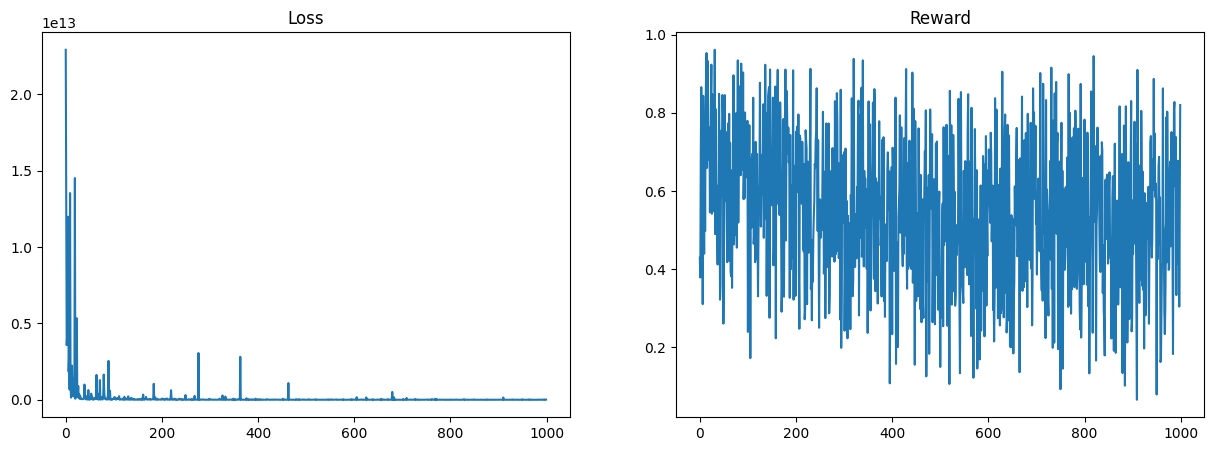

In [31]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('Loss')
plt.plot(loss)
plt.subplot(122)
plt.title('Reward')
plt.plot([r.item() for r in rewards[:]])
plt.show()

In [ ]:
sample_batch(1).shape